In [1]:
# Turn off warnings 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')



In [305]:
## Cleaning supplies! 

from nltk.corpus import stopwords
import string
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import spacy

from textblob import TextBlob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
## loading data
df = pd.read_csv('data/reviews.csv', index_col='Unnamed: 0')

# Remove nan text
df.dropna(subset=['Review Text'], inplace= True)

In [4]:
df.shape

(22641, 10)

In [446]:
df.reset_index(inplace= True)
df

,index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
22636,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [105]:
df.corr()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
Clothing ID,1.000000,0.017688,-0.018454,-0.014874,0.044902
Age,0.017688,1.000000,0.029962,0.034208,0.040850
Rating,-0.018454,0.029962,1.000000,0.792568,-0.060984
Recommended IND,-0.014874,0.034208,0.792568,1.000000,-0.065923
Positive Feedback Count,0.044902,0.040850,-0.060984,-0.065923,1.000000


In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              22641 non-null  int64 
 1   Age                      22641 non-null  int64 
 2   Title                    19675 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   22641 non-null  int64 
 5   Recommended IND          22641 non-null  int64 
 6   Positive Feedback Count  22641 non-null  int64 
 7   Division Name            22628 non-null  object
 8   Department Name          22628 non-null  object
 9   Class Name               22628 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.4+ MB


In [104]:
df['Review Text'].iloc[150]

'This top is so much better in person. i do not agree with some of the other reviews about the fabric being scratchy. it is not and i have sensitive skin. i love this top and have got lots of compliments.'

In [243]:
# Corpus
corpus = df[['Review Text']].values.tolist()
corpus = [''.join(element) for element in corpus]

In [244]:
corpus[1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [245]:
#corpus is a list of strings
type(corpus)

list

In [204]:
my_stopwords = ['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your',\
                'yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself',\
                'it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who','whom',\
                'this','that',"that'll",'these','those','am','is','are','was','were','be','been','being','have',\
                'has','had','having','do','does','did','doing' 'a','an','the','and','but','if','or','because','as',\
                'until','while','of','at','by','for','with','about','against','between','into','during','before',\
                'after','to','from','in','out','on','off','over','under','again','further','then','once',\
                'here','there','when','where','why','how','all','any','both','each','few','more','most','other',\
                'some','such','nor','only','own','same','so','than','too','very','s','t','can','will','just','don',\
                "don't",'should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",'couldn',\
                "couldn't",'could','a',"'s", "'m",\
                'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven', "haven't",'isn',"isn't",\
                'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",\
                'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'would']



In [109]:
pt = string.punctuation + "''"
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\'\''

In [34]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"isn't": "is not",
"mayn't": "may not",
"mightn't": "might not",
"mightn't've": "might not have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"wasn't": "was not",
"weren't": "were not",
"won't": "will not",
"won't've": "will not have",
"wouldn't": "would not",
"wouldn't've": "would not have",
}

In [35]:
text="What's the best way to ensure this?"
for word in text.split():
    if word.lower() in contractions:
        text = text.replace(word, contractions[word.lower()])
print(text)

What's the best way to ensure this?


In [248]:
def clean_nots(docs):
    not_docs=[]
    for doc in docs:
        for word in doc.split():
            if word in contractions:
                doc = doc.replace(word,contractions[word])
        not_docs.append(doc)
    return not_docs


In [249]:
corpus[7]

"I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size..."

In [252]:
corpus_w_nots = clean_nots(corpus)

In [256]:
corpus_w_nots[0:2]

['Absolutely wonderful - silky and sexy and comfortable',
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.']

In [177]:
def clean_tokens(docs):
    ''' returns a list of lists: the clean tokens of docs'''
    docs_tokens=[]
    for doc in docs:
        clean_tokens = []
        tokens = word_tokenize(doc)
        for token in tokens:
            if token.lower() not in my_stopwords and token not in pt:
                clean_tokens.append(token.lower())
        docs_tokens.append(clean_tokens)    
    return docs_tokens

In [257]:
c_tokens = clean_docs(corpus_w_nots)


In [355]:
#c_tokens is a list of token lists for each document


In [346]:
# make a lemmatization function that keeps 'not'
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    tokens_out = []
    for lst in texts:
        doc = nlp(" ".join(lst)) 
        lemma_tokens=[]
        for token in doc:
            if token.text == 'not':
                lemma_tokens.append(token.text)
            else:
                if token.pos_ in allowed_postags:
                    lemma_tokens.append(token.lemma_)
        tokens_out.append(lemma_tokens)
    return tokens_out

In [347]:
trial = [['ordered','carbon','not','scared'], ['hello', 'kitty', 'kitties', 'not']]
lemmatization(trial)

[['order', 'carbon', 'not', 'scare'], ['kitty', 'kitty', 'not']]

In [356]:
#lemmatizing
tokens_lemmatized= lemmatization(c_tokens)

In [315]:
type(tokens_lemmatized)

list

In [401]:
#tokens_lemmatized[7]

In [370]:
# Add N-grams ; documents is a list of list of all tokens and N-grams. It has the word 'not'
documents = [row + list(map(lambda ng: '-'.join(ng), ngrams(row, 2))) for row in tokens_lemmatized]

In [392]:
type(documents[0])

list

In [544]:
# removing the single word 'not' from the docs
docs_filtered = []
for row in documents:
    result = filter(lambda val: val !=  'not', row) 
    docs_filtered.append(list(result))

#docs_filtered[7]

In [414]:
# attaching everything as a string per row
token_strings = [" ".join(row) for row in docs_filtered]
len(token_strings)

22641

In [449]:
df_and_token= df.copy()

In [482]:
df_and_token['token_strings'] = token_strings
df_and_token.iloc[7,-1]

'order carbon store pick ton stuff always try use top pair skirt pant go color really nice charcoal shimmer go well pencil skirt flare pant compaint bit big sleeve long go petite also bit loose xxs keep wil ldecide later light color already sell small size order-carbon carbon-store store-pick pick-ton ton-stuff stuff-always always-try try-use use-top top-pair pair-skirt skirt-pant pant-go go-color color-really really-nice nice-charcoal charcoal-shimmer shimmer-go go-well well-pencil pencil-skirt skirt-flare flare-pant pant-compaint compaint-bit bit-big big-sleeve sleeve-long long-not not-go go-petite petite-also also-bit bit-loose loose-xxs xxs-keep keep-wil wil-ldecide ldecide-later later-light light-color color-already already-sell sell-small small-size'

In [545]:
df_and_token.head(2)

,index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,token_strings
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable ab...
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happen find store glad ...


In [528]:
df_and_token.to_csv('data/df_and_token.csv')

## Make a tfidf matrix with token strings

In [546]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [553]:
tfidf = TfidfVectorizer(token_pattern = '\s([A-Za-z0-9-]+)\s',
                        ngram_range = (1,1))

In [554]:
document_tfidf = tfidf.fit_transform(df_and_token['token_strings'])

In [555]:
document_tfidf_matrix= document_tfidf.todense()

In [556]:
doc_word_matrix = pd.DataFrame(data = document_tfidf_matrix, columns= tfidf.get_feature_names())
doc_word_matrix.head()

,-,--ankle,--attached,--baby,--breathable,--bummed,--calf,--check,--clip,--closing,...,zips-front,zips-not,zombie-movie,zone,zone-style,zone-swing,zoolander-derelict,zoom,zooming,zuma-reference
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [557]:
doc_word_matrix['Keyword'] = doc_word_matrix.idxmax(axis=1)


In [558]:
doc_word_matrix.head()

,-,--ankle,--attached,--baby,--breathable,--bummed,--calf,--check,--clip,--closing,...,zips-not,zombie-movie,zone,zone-style,zone-swing,zoolander-derelict,zoom,zooming,zuma-reference,Keyword
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,silky-sexy
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,petite
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,layer
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flirty-fabulous
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,adjustable-front


In [559]:
doc_word_matrix.Keyword

0               silky-sexy
1                   petite
2                    layer
3          flirty-fabulous
4         adjustable-front
               ...        
22636           price-easy
22637         awkward-nice
22638     online-different
22639        dress-deliver
22640    platinum-feminine
Name: Keyword, Length: 22641, dtype: object

In [ ]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

## Vectorizer

In [503]:
vectorizer = CountVectorizer(max_features= 5000, token_pattern='\s([A-Za-z0-9-]+)\s')
cwm = vectorizer.fit_transform(df_and_token['token_strings'])
data_dense = cwm.todense()

In [504]:
type(data_dense) , data_dense.shape

(numpy.matrix, (22641, 5000))

In [526]:
# Check to see if not-ngrams worked
#vectorizer.get_feature_names()[2800:2900]

In [428]:
word_matrix = pd.DataFrame(data = data_dense, columns= vectorizer.get_feature_names())

In [447]:
word_matrix['Clothing ID'] = df['Clothing ID']
word_matrix

,00p,0p,0petite,10,108,10p,12p,130,1960,1st,...,yummy,zig,zip,zipped,zipper,zipping,zips,zone,zoom,Clothing ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,767
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1080
2,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,1077
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1049
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1104
22637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,862
22638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1104
22639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1084


### playing with item 868

In [453]:
df_868 = df_and_token[df_and_token['Clothing ID']==868]
df_868.shape

(414, 12)

In [454]:
df_868

,index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,token_strings
166,173,868,51,Great for summer,Love this cream sleeveless top....it goes with...,4,1,0,General Petite,Tops,Knits,love cream sleeveless top go dress go top summ...
259,270,868,61,Nice color,I liked the color of this top but i didn't rea...,3,1,0,General,Tops,Knits,like color top really ruffle stitch middle loo...
265,276,868,55,Pretty and feminine,Pretty top. love the color and the large ruffl...,5,1,0,General,Tops,Knits,pretty top love color large ruffle make great ...
266,277,868,83,Sooooooooo cute!,"Love this top!\nit is a full/ swing top, but t...",5,1,1,General,Tops,Knits,love top swing top slightly short length balan...
267,278,868,35,Peplum hem tee,The styling of this top is really cute. it fit...,3,1,2,General,Tops,Knits,style top really cute fit perfectly shoulder g...
...,...,...,...,...,...,...,...,...,...,...,...,...
22192,23026,868,53,Might want to size down,I just got this in the mail today. it's really...,4,1,33,General,Tops,Knits,get mail today really cute put definitely mean...
22198,23032,868,30,If curvy...stay away!,I had such high hopes for this shirt! i got it...,2,0,4,General,Tops,Knits,high hope shirt get black moss beautiful color...
22199,23033,868,86,Loved these!,I saw online and bought in white and moss! mos...,5,1,8,General,Tops,Knits,see online buy white moss moss dark person 30f...
22220,23054,868,50,Flattering and comfy!,This top is my favorite of the season! plannin...,5,1,1,General,Tops,Knits,top favorite season planning order black top-f...


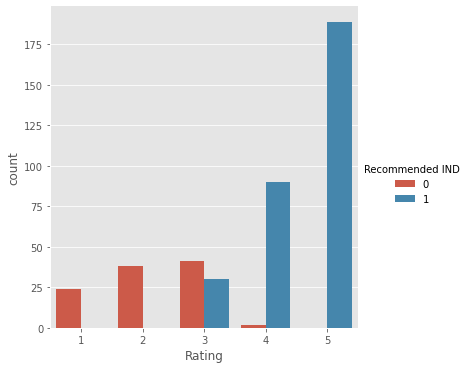

In [561]:
sns.catplot(data=df_868, kind='count',x='Rating',hue='Recommended IND')

In [571]:
well = df_868[df_868.Rating<4]['Review Text']
well.values


array(["I liked the color of this top but i didn't really like the ruffled stitching around the middle. it looks like someone just tacked on the bottom half. i bought this for my daughter and she likes it. i think it is comfortable and a good top to knock around in.",
       "The styling of this top is really cute. it fits perfectly on the shoulders and gets bigger at the hem for the baby doll look. my biggest complaint is the quality! it's really cheap and feels like the quality i would expect to see at a cheap retailer. it catches lint like crazy and because the hem is just a pearl edge, it curls really badly. i buy quite a bit from here and this is the worst quality item i have seen in a long time. not worth the $$ if paying full price.",
       "Like the other reviewer said this top is extremely wide and boxy. it must be pinned in the picture online. it's very frustrating when they do that. thank goodness i didn't pay for shipping! for reference, i'm 5'2 and 135 pounds and bought t

In [562]:
vectorizer5 = CountVectorizer(max_features=5000, token_pattern='\s([A-Za-z0-9-]+)\s')
cwm5 = vectorizer5.fit_transform(df_868[df_868.Rating<4]['token_strings'])
data_dense_868neg = cwm5.todense()
data_dense_868neg.shape

(133, 2080)

In [564]:
lda_output= lda_model.fit_transform(data_dense_868neg)
panel = pyLDAvis.sklearn.prepare(lda_model, cwm5, vectorizer5, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  23.326986
3       51.163364 -159.968018       2        1  21.843467
2      -73.144554   21.523815       3        1  19.084746
0      -66.410133 -110.606438       4        1  18.404222
4       54.417324   12.443444       5        1  17.340579, topic_info=        Term       Freq      Total Category  logprob  loglift
1811     top  40.000000  40.000000  Default  30.0000  30.0000
1506   shirt  18.000000  18.000000  Default  29.0000  29.0000
879     look  32.000000  32.000000  Default  28.0000  28.0000
491   fabric  11.000000  11.000000  Default  27.0000  27.0000
262    color  14.000000  14.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
601    front   2.158740   5.143274   Topic5  -5.5685   0.8840
942      low   1.672845   4.190650   Topic5  -5.8234   0.8338
1779   think   1.600852   4.528561   Topic5  -5.8674   0.7123
800    large   1.747610   9.404123   Topic5  -5.7797   0.0692
459     even   1.494525   3.232540   Topic5  -5.9362   0.9807

[236 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7         4  0.508857  absolutely
17        3  0.693508         add
29        4  0.813728      almost
35        4  0.947217        also
58        3  0.774270      appear
...     ...       ...         ...
2031      5  0.554787    wide-not
2048      3  0.964956        work
2059      3  0.423553       worth
2059      4  0.423553       worth
2066      5  0.828714          xs

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])

In [513]:
vectorizer2 = CountVectorizer(max_features=5000, token_pattern='\s([A-Za-z0-9-]+)\s')
cwm2 = vectorizer2.fit_transform(df_868['token_strings'])
data_dense_868 = cwm2.todense()
data_dense_868.shape

(414, 5000)

In [514]:
word_matrix_868 = pd.DataFrame(data = data_dense_868, columns= vectorizer2.get_feature_names())
word_matrix_868

,-,--large,--riff,--sheer,--thigh,--wide,32b,34a,34a-buy,34b,...,yellowish,yesterday,yesterday-store,yet,yet-accentuate,yet-quite,young-woman,yuck,zipper-difficult,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [483]:
vectorizer2.get_feature_names()

['30dd',
 '30f',
 '32b',
 '32d',
 '34a',
 '34b',
 '34c',
 '34d',
 '34dd',
 '34ddd',
 '36b',
 '36c',
 '36dd',
 '36h',
 '40d',
 'able',
 'absolutely',
 'accent',
 'accentuate',
 'accessorize',
 'accessory',
 'accidental',
 'accidentally',
 'accord',
 'accuracy',
 'actual',
 'actuality',
 'actually',
 'add',
 'addition',
 'adjust',
 'adjustable',
 'adorable',
 'adore',
 'advertise',
 'advice',
 'aesthetic',
 'afraid',
 'afternoon',
 'aged',
 'ago',
 'agree',
 'air',
 'airly',
 'airy',
 'aka',
 'allow',
 'alluring',
 'almost',
 'alone',
 'alot',
 'already',
 'also',
 'alter',
 'alteration',
 'always',
 'amazing',
 'amount',
 'amp',
 'angle',
 'annoyed',
 'anyway',
 'apparent',
 'apparently',
 'appeal',
 'appear',
 'appreciate',
 'appropriate',
 'appropriately',
 'architectural',
 'area',
 'arm',
 'armhole',
 'armpit',
 'around',
 'arrive',
 'arty',
 'ask',
 'assume',
 'astoria',
 'asymmetric',
 'asymmetrical',
 'athletic',
 'attentio',
 'attention',
 'attractive',
 'available',
 'avoid',
 

In [448]:
#vectorizer.get_feature_names()

In [485]:
# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [542]:
lda_model = LatentDirichletAllocation(n_components=5,            # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=1,              # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(word_matrix_868)


In [543]:
panel = pyLDAvis.sklearn.prepare(lda_model, cwm2, vectorizer2, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  26.471848
1       51.163364 -159.968018       2        1  20.371744
4      -73.144554   21.523815       3        1  18.614550
3      -66.410133 -110.606438       4        1  17.518490
0       54.417324   12.443444       5        1  17.023368, topic_info=          Term        Freq       Total Category  logprob  loglift
2198      look   76.000000   76.000000  Default  30.0000  30.0000
4314       top  136.000000  136.000000  Default  29.0000  29.0000
4724      wear   70.000000   70.000000  Default  28.0000  28.0000
3470     shirt   51.000000   51.000000  Default  27.0000  27.0000
3627      size   59.000000   59.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
4151       tee    7.137219   10.985353   Topic5  -5.4533   1.3393
3252    return    7.353272   13.075438   Topic5  -5.4235   1.1950
3538     short    7.082537   15.425602   Topic5  -5.4610   0.9922
3562  shoulder    5.104833   14.478288   Topic5  -5.7884   0.7281
111       also    4.960413   17.115473   Topic5  -5.8171   0.5321

[211 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
39        5  0.830845  actually
46        4  0.984904       add
95        4  0.971277    almost
111       1  0.701120      also
111       5  0.292133      also
...     ...       ...       ...
4818      3  0.969969      well
4854      1  0.947519     white
4874      1  0.857595      wide
4874      4  0.122514      wide
4930      1  0.936214      work

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])

In [489]:
lda_output.shape, type(lda_output)

((414, 5), numpy.ndarray)

In [490]:
dtm = np.matrix(lda_output)
#pyLDAvis.sklearn.prepare(lda_model, dtm, vectorizer)

## playing with item 1078

In [527]:
df_1078 = df_and_token[df_and_token['Clothing ID']==1078]
df_1078.shape

(987, 12)

In [575]:
df_and_token[df_and_token['Clothing ID'] ==868].Title.values

array(['Great for summer', 'Nice color', 'Pretty and feminine',
       'Sooooooooo cute!', 'Peplum hem tee', nan, 'Clever white edges',
       nan, nan, nan, 'Cute tunic', 'Pretty and feminine',
       'I wanted to love this shirt.', 'Super cute with right body style',
       'Nice simple staple', 'Wide', 'So cute!', 'Love it!',
       'Comfortable style', 'Comfy and lovely', 'Adorable!', 'Great top!',
       'Great w/ black crops', 'Beautiful unique top', 'Love this top',
       nan, 'Not good', "Doesn't wash well :(",
       'Great top if you get the right size!!', 'Adorable',
       'Cute and swingy', nan, 'I really like it', 'Love it!!', 'Bulky!',
       'So great', 'No!!', 'Love it', 'Modern swing', nan,
       'Cute top, poor fit', 'Unique but runs big',
       'So comfy and versatile!',
       'Like it so much i ordered a second one!', 'Cute top',
       'Love the color, design and flow', 'Beautiful design but too big',
       'Go to tee', 'So tent-like and unflattering!',
     

In [529]:
vectorizer3 = CountVectorizer(max_features=5000, token_pattern='\s([A-Za-z0-9-]+)\s')
cwm3 = vectorizer3.fit_transform(df_1078['token_strings'])
data_dense_1078 = cwm3.todense()
data_dense_1078.shape

(987, 5000)

In [531]:
word_matrix_1078 = pd.DataFrame(data = data_dense_1078, columns= vectorizer3.get_feature_names())

In [532]:
lda_model = LatentDirichletAllocation(n_components=12,            # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=1,              # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(word_matrix_1078)

In [534]:
panel = pyLDAvis.sklearn.prepare(lda_model, cwm3, vectorizer3, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0        5.310529  171.049652       1        1  13.667423
2      136.304657   23.800941       2        1  10.326632
4      101.190552  -84.985191       3        1   8.657740
3     -106.824867  148.841736       4        1   8.201422
6      -44.365761   78.632721       5        1   8.118467
9       43.884090   73.474022       6        1   7.856910
8      114.093971  135.933029       7        1   7.702099
10    -119.727142  -72.077179       8        1   7.503903
1      -49.518208   -9.617325       9        1   7.373043
7     -141.938736   40.055210      10        1   6.976763
5       38.731544  -14.776019      11        1   6.945904
11     -10.944340 -107.193344      12        1   6.669694, topic_info=             Term        Freq       Total Category  logprob  loglift
461         dress  682.000000  682.000000  Default  30.0000  30.0000
1105         look  176.000000  176.000000  Default  29.0000  29.0000
735           fit  186.000000  186.000000  Default  28.0000  28.0000
3305         size  196.000000  196.000000  Default  27.0000  27.0000
4608         wear  156.000000  156.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3247         send    5.908592    6.634451  Topic12  -5.3812   2.5917
1690       orange    5.841056    6.566936  Topic12  -5.3927   2.5905
797          form    5.815364    6.541230  Topic12  -5.3971   2.5900
1339  normal-size    5.807354    6.533240  Topic12  -5.3984   2.5898
4148   transition    5.770115    6.495967  Topic12  -5.4049   2.5891

[398 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
7         2  0.903704              34b
10       10  0.833740              34d
14       11  0.881281             able
17        5  0.969766       absolutely
19        6  0.946261  absolutely-love
...     ...       ...              ...
4813      2  0.674897             work
4813     11  0.320576             work
4924      3  0.924249               xs
4948      1  0.957520             year
4990     11  0.913148           zipper

[370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 7, 10, 9, 11, 2, 8, 6, 12])

## playing with the whole corpus Did not work


In [535]:
vectorizer4 = CountVectorizer(max_features=5000, token_pattern='\s([A-Za-z0-9-]+)\s')
cwm4 = vectorizer4.fit_transform(df_and_token['token_strings'])
data_dense_all = cwm4.todense()
data_dense_all.shape

(22641, 5000)

In [536]:
word_matrix_all = pd.DataFrame(data = data_dense_all, columns= vectorizer4.get_feature_names())

In [537]:
lda_model = LatentDirichletAllocation(n_components=12,           # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=1,              # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(word_matrix_all)

KeyboardInterrupt: 

In [ ]:
panel = pyLDAvis.sklearn.prepare(lda_model, cwm4, vectorizer4, mds='tsne')
panel